In [1]:
import os 
import pandas as pd
import numpy as np
import pickle as pkl
import time

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection

import networkx as nx

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

## Import the data

In [29]:
data_path = '../data/graphs_per_doc/'

features_files = [f for f in os.listdir(data_path) if f.startswith("txt_feature")]
feature_file = open(data_path + features_files[0],'rb')
features = pkl.load(feature_file)
feature_file.close()

files = [f for f in os.listdir(data_path) if f.startswith("txt_graph")]

graphs = []
graph_labels = []


In [30]:
i = 66
print(i)
file = open(data_path + files[i],'rb')

graph = pkl.load(file)
label = pkl.load(file)

66


In [26]:
features.loc[["1Mbps", "fsdx"]]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [10]:
graphs.append(StellarGraph.from_networkx(graph, node_features = features.loc[list(graph.nodes)]))
graph_labels.append(label)

file.close()    

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1m,0.085449,-0.012695,-0.215820,0.087891,-0.072266,-0.002991,-0.219727,0.049561,0.289062,-0.120605,...,-0.021973,-0.070312,-0.183594,-0.038086,-0.058350,0.090332,-0.063477,-0.001236,-0.224609,-0.253906
1Xtra,-0.324219,-0.138672,-0.059326,0.001106,0.072754,-0.164062,-0.300781,-0.072754,-0.058594,0.000315,...,0.136719,0.302734,-0.322266,0.034180,-0.189453,-0.412109,-0.149414,0.047119,0.192383,0.027344


In [12]:
# load and concatenate all graph data
for i in range(len(files)):
    print(i)
    file = open(data_path + files[i],'rb')
 
    graph = pkl.load(file)
    label = pkl.load(file)
    
    graphs.append(StellarGraph.from_networkx(graph, node_features = features.loc[list(graph.nodes)]))
    graph_labels.append(label)
    
    file.close()    
graph_labels = np.array(graph_labels).argmax(1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [4]:
print(graphs[1].info())
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

StellarGraph: Undirected multigraph
 Nodes: 260, Edges: 390

 Node types:
  default: [260]
    Features: float32 vector, length 300
    Edge types: default-default->default

 Edge types:
    default-default->default: [390]
        Weights: all 1 (default)
        Features: none


,nodes,edges
count,66.0,66.0
mean,188.9,287.7
std,73.1,131.4
min,89.0,109.0
25%,131.0,188.2
50%,173.5,254.0
75%,227.5,378.8
max,422.0,688.0


### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class. Note that `graphs` is a list of `StellarGraph` graph objects.

In [5]:
generator = PaddedGraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `GraphClassification` class together with standard `tf.Keras` layers, e.g., `Dense`. 

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and `relu` activations. The last layer is the output layer with a single unit and `sigmoid` activation.

![](graph_classification_architecture.png)

In [6]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.4,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=5, activation="softmax")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss = sparse_categorical_crossentropy, metrics=["acc"])

    return model

### Train the model

We can now train the model using the model's `fit` method. First, we specify some important training parameters such as the number of training epochs, number of fold for cross validation and the number of time to repeat cross validation.

In [7]:
epochs = 1000  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [8]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

The method `train_fold` is used to train a graph classification model for a single fold of the data.

In [9]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [10]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels[train_index], batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels[test_index], batch_size=batch_size
    )

    return train_gen, test_gen

In [11]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)



In [12]:
for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)
    start_time = time.time()
    history, acc = train_fold(model, train_gen, test_gen, es, epochs)
    print("--- %s seconds ---" % (time.time() - start_time))
    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...
--- 193.6311583518982 seconds ---
Training and evaluating on fold 2 out of 10...
--- 154.71643137931824 seconds ---
Training and evaluating on fold 3 out of 10...
--- 305.5208959579468 seconds ---
Training and evaluating on fold 4 out of 10...
--- 191.33619165420532 seconds ---
Training and evaluating on fold 5 out of 10...
--- 162.86702632904053 seconds ---
Training and evaluating on fold 6 out of 10...
--- 420.74097084999084 seconds ---
Training and evaluating on fold 7 out of 10...
--- 157.62612175941467 seconds ---
Training and evaluating on fold 8 out of 10...
--- 155.4628849029541 seconds ---
Training and evaluating on fold 9 out of 10...
--- 140.98613619804382 seconds ---
Training and evaluating on fold 10 out of 10...
--- 196.7372317314148 seconds ---


In [13]:
model = create_graph_classification_model(generator)

In [14]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, None, 300)    0           input_31[0][0]                   
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution_20 (GraphConv (None, None, 64)     19264       dropout_20[0][0]                 
                                                                 input_33[0][0]            

In [27]:
history.history

{'loss': [1.1388312578201294,
  0.4769447445869446,
  0.26710861921310425,
  0.16763244569301605,
  0.10753024369478226,
  0.08825007826089859,
  0.08893487602472305,
  0.07965099811553955,
  0.05682373046875,
  0.04734761267900467,
  0.074284628033638,
  0.07801295816898346,
  0.03512813523411751,
  0.023243965581059456,
  0.03758822754025459,
  0.049914468079805374,
  0.03951991721987724,
  0.0323437824845314,
  0.07008488476276398,
  0.059224795550107956,
  0.03411073237657547,
  0.04487738013267517,
  0.01139173936098814,
  0.021265504881739616,
  0.06419026106595993,
  0.01975131407380104,
  0.018751347437500954,
  0.011254660785198212,
  0.05485978722572327,
  0.02679789438843727,
  0.004423870239406824,
  0.011428373865783215,
  0.05460783839225769,
  0.025186220183968544,
  0.028524303808808327,
  0.0098981112241745,
  0.008641587570309639,
  0.01425840612500906,
  0.007877021096646786,
  0.0470338799059391,
  0.021695636212825775,
  0.022609863430261612,
  0.006152599118649959

In [28]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 98.5% and std: 0.7%


Finally, we plot a histogram of the accuracy of all `n_repeats x folds` models trained (50 in total).

Text(0, 0.5, 'Count')

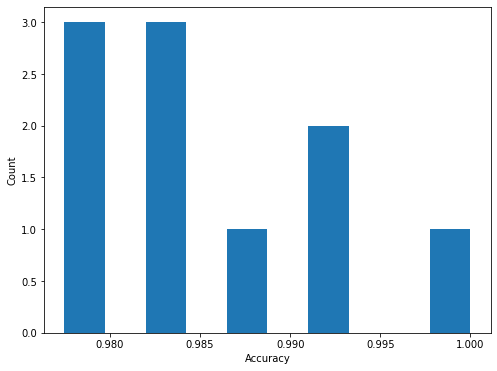

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")